In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.preprocessing import MinMaxScaler
from folium.plugins import HeatMap
from google.colab import files




In [3]:

# Upload new earthquake dataset
uploaded = files.upload()

Saving edata_tes1.csv to edata_tes1.csv


<ipython-input-4-f6b4877f9596>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


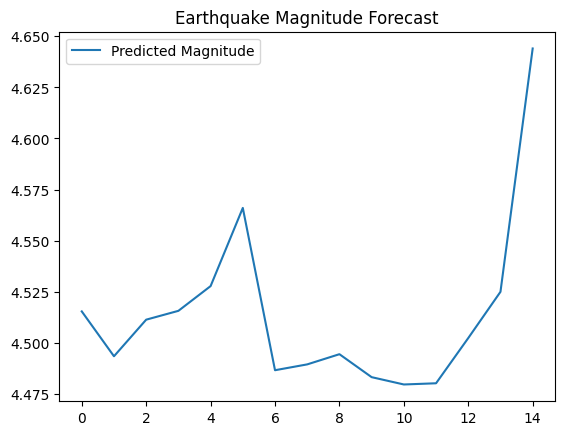

In [4]:



# Get the uploaded filename
for filename in uploaded.keys():
    df = pd.read_csv(filename)

# Rename 'Time' column to 'Timestamp' if it exists
if 'time' in df.columns:
    df.rename(columns={'time': 'Timestamp'}, inplace=True)
# Select necessary columns
selected_columns = ['Timestamp', 'Mag', 'Lat', 'Lon', 'Depth km']
df = df[selected_columns]

# Ensure correct data types
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(by='Timestamp')  # Ensure chronological order

# Handle missing values
df.dropna(inplace=True)

# Feature Scaling
feature_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_features = ['Lat', 'Lon', 'Depth km']
df[scaled_features] = feature_scaler.fit_transform(df[scaled_features])
df[['Mag']] = target_scaler.fit_transform(df[['Mag']])

# Prepare data for LSTM
def create_sequences(data, target_column, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length].values)
        y.append(data.iloc[i+sequence_length][target_column])
    return np.array(X), np.array(y)

# Define target variable
target_column = 'Mag'  # Predicting Magnitude
sequence_length = 10  # Use last 10 observations

X, _ = create_sequences(df[scaled_features + ['Mag']], target_column, sequence_length)

# Load pre-trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Project/Code/earthquake-master/Model/lstm_earthquake_model.keras')

# Predict using the model
y_pred = model.predict(X)

# Inverse scaling
y_pred_actual = target_scaler.inverse_transform(y_pred.reshape(-1, 1))

# Plot results
plt.plot(y_pred_actual, label='Predicted Magnitude')
plt.legend()
plt.title('Earthquake Magnitude Forecast')
plt.show()

# Geospatial Visualization using Folium
map_center = [df['Lat'].mean(), df['Lon'].mean()]
earthquake_map = folium.Map(location=map_center, zoom_start=5)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Lat'], row['Lon']],
        radius=row['Mag'] * 2,
        color='red' if row['Mag'] > 5 else 'blue',
        fill=True,
        fill_color='red' if row['Mag'] > 5 else 'blue',
        fill_opacity=0.6,
        popup=f"Magnitude: {row['Mag']:.2f}, Depth: {row['Depth km']} km"
    ).add_to(earthquake_map)



In [5]:
import datetime
import os

In [6]:
# Save the map with a timestamped filename
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = "/content/drive/MyDrive/Project/Code/earthquake-master/results/"
os.makedirs(save_path, exist_ok=True)
save_filename = os.path.join(save_path, f"earthquake_map_{current_time}.html")
earthquake_map.save(save_filename)
print(f"Geospatial map saved as {save_filename}")


Geospatial map saved as /content/drive/MyDrive/Project/Code/earthquake-master/results/earthquake_map_20250327_055328.html
